In [1]:
import pandas as pd
from openpyxl import load_workbook
import lagrangian_case as lc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
from cycler import cycler
import matplotlib as mpl
import os
import utils
import met_utils as mu
import xarray as xr
from matplotlib import dates as mpldates
from scipy import stats
old_settings = np.seterr(invalid='ignore')  #seterr to known value
import warnings
import datetime as dt
import glob
from CSET_data_classes import CSET_Flight_Piece, CSET_Flight
warnings.simplefilter("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
combined_cases = {}
for key, case in lc.all_cases.items():
    if key not in [6, 10]:
        continue
# case = lc.all_cases[1]
    print(key)
    TLC = lc.TrajectoryCase(case['TLC_name'])
    TLC.add_traj_data()
    ALC = lc.AircraftCase(case['ALC_name'])
#     ALC.add_ERA_data()
    ALC.add_precip_data()
    CLC = lc.CombinedCase(ALC, TLC, number=key)
    combined_cases[key] = CLC
#     CLC.plot(save=True)

6
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
10
adding ERA ens w_vert
adding ERA ens w_vert


In [3]:
def get_profs(case):
    out_ALC_profiles = {}
    for out_seq in case.ALC.outbound_sequences:
        profile_times = utils.get_leg_times_by_sequence(flightnum=int(case.ALC.outbound_flight[2:]), sequence=out_seq, leg='d')
        fp = CSET_Flight_Piece(case.ALC.outbound_flight, *profile_times)
        fp.add_ERA_data()
        best_i = np.argmin(np.abs(fp.ERA_data.time.values - fp.flight_data.time.values[int(len(fp.flight_data.time.values)/2)]))
        fp.ERA_data = fp.ERA_data.isel(time=best_i)
        out_ALC_profiles[out_seq] = fp

    ret_ALC_profiles = {}
    for ret_seq in case.ALC.return_sequences:
        profile_times = utils.get_leg_times_by_sequence(flightnum=int(case.ALC.return_flight[2:]), sequence=ret_seq, leg='d')
        fp = CSET_Flight_Piece(case.ALC.return_flight, *profile_times)
        fp.add_ERA_data()
        best_i = np.argmin(np.abs(fp.ERA_data.time.values - fp.flight_data.time.values[int(len(fp.flight_data.time.values)/2)]))
        fp.ERA_data = fp.ERA_data.isel(time=best_i)
        ret_ALC_profiles[ret_seq] = fp

    #rough estimate of when the outbound and return samplings were
    out_time = case.ALC.outbound_flight_data.time.values[int(len(case.ALC.outbound_flight_data.time.values)/2)]
    ret_time = case.ALC.return_flight_data.time.values[int(len(case.ALC.return_flight_data.time.values)/2)]

    # chop out ERA profiles from trajectory start/resampling points
    out_TLC_profiles = {}
    ret_TLC_profiles = {}
    for k,v in case.TLC.traj_data.items():
        out_TLC_profiles[k] = v.sel(time=out_time, method='nearest')
        ret_TLC_profiles[k] = v.sel(time=ret_time, method='nearest')  
        
    return{"out_ALC_profs": out_ALC_profiles,
           "ret_ALC_profs": ret_ALC_profiles,
           "out_TLC_profs": out_TLC_profiles,
           "ret_TLC_profs": ret_TLC_profiles}

case_6_profs = get_profs(combined_cases[6])
case_10_profs = get_profs(combined_cases[10])


670.7205
837.9597
2372.6108
1242.5709
1564.1511
1828.8195
837.9597
837.9597
670.7205
670.7205
2372.6108
2372.6108
1242.5709
1242.5709
1564.1511
1564.1511
1828.8195
1828.8195


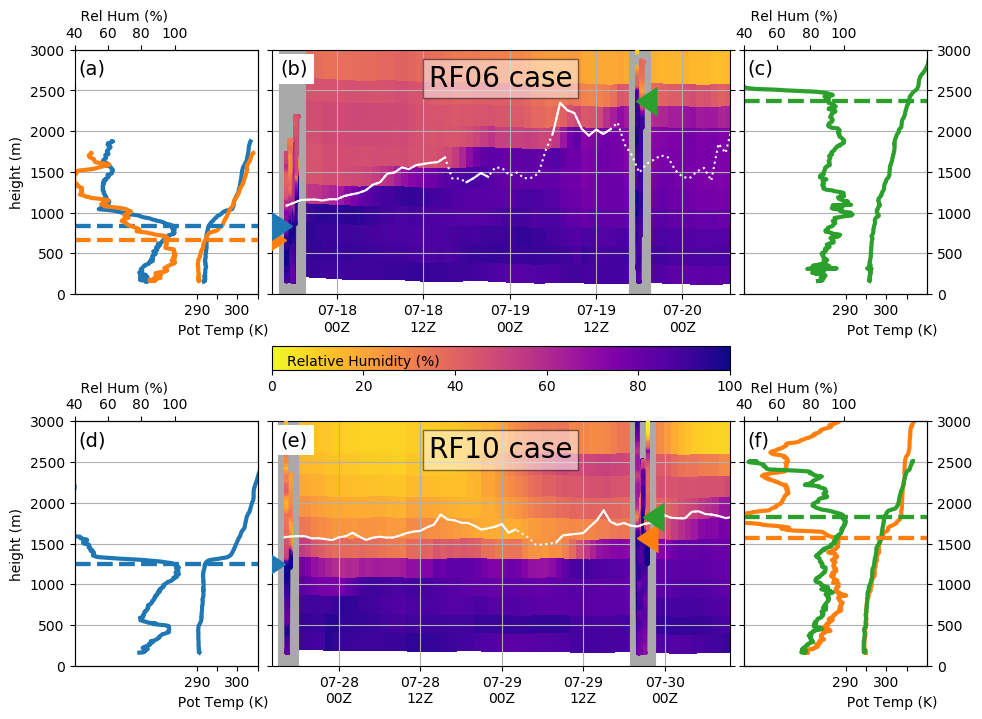

In [13]:
def add_profs_to_plot(axb, ALC_profiles, TLC_profiles, title, colors=plt.rcParams['axes.prop_cycle'].by_key()['color']):

    mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)
    axt = axb.twiny()

    def plot_with_zi(axi, x, z, t, p, rh=None, method='Peter2', **kwargs):
            if method=='usual':
                inv = mu.quick_inversion(z, t, p, smooth_t=True)
            elif method=='Peter2':
                inv = {}
                inv['z_bot'] = mu.Peter2_inv(z, rh, theta)
    #             elif method=='Peter1':
    #                 inv = {}
    #                 inv['z_bot'] = mu.Peter2_inv(z, theta, rh)
            lab = 'inv={:0.0f} m'.format(inv['z_bot'])
            x = axi.plot(x, z, **kwargs)
            axi.axhline(inv['z_bot'], c=x[0].get_color(), ls='--', lw=x[0].get_linewidth(), label=lab) #ls=x[0].get_linestyle()
            print(inv['z_bot'])
            return x
        
    for k, ALC_prof in ALC_profiles.items():
        theta = mu.theta_from_p_T(p=ALC_prof.ERA_data.level.values, T=ALC_prof.ERA_data.ERA_t.values)
        ac = plot_with_zi(axt, x=ALC_prof.flight_data.RHUM.values, z=ALC_prof.flight_data.GGALT.values, t=ALC_prof.flight_data.ATX.values+273.15, p=ALC_prof.flight_data.PSX.values, rh=ALC_prof.flight_data.RHUM.values, 
                          method='usual', label='GV (seq {})'.format(k), lw=3)      
        ac = plot_with_zi(axb, x=ALC_prof.flight_data.THETA.values, z=ALC_prof.flight_data.GGALT.values, t=ALC_prof.flight_data.ATX.values+273.15, p=ALC_prof.flight_data.PSX.values, rh=ALC_prof.flight_data.RHUM.values, 
                          method='usual', label='GV (seq {})'.format(k), lw=3, c=ac[0].get_color())

        axt.set_xlabel('    Rel Hum (%)                       ')
        axb.set_xlabel('                          Pot Temp (K)')
        axt.set_ylim(0,3000)
        axb.set_xlim(260, 305)
        axb.set_xticks([290, 295, 300, 305])
        axb.set_xticklabels([290, '', 300, ''])
        axt.set_xlim(40, 150)
        axt.set_xticks([40, 60, 80, 100])
        axb.grid(True, axis='y')


def add_RH_to_plot(ax, case, trajname, colors, label):
    ax.set_prop_cycle(cycler(color=colors))
    def add_inv_to_plot(ax, fp, **kwargs):
        for seq in fp.sequences:
            prof = fp.flight_data.where(np.logical_and(fp.flight_data.sequence == seq, fp.flight_data.leg == 'd'), drop=True)
            inv_dec = mu.calc_decoupling_and_zi_from_flight_data(prof)
#             label = "{:0.0f}N, {:0.0f}E".format(inv_dec['lat'], inv_dec['lon'])
            print(inv_dec['z_bot'])
            ax.plot(utils.as_datetime(inv_dec['time']), inv_dec['z_bot'], **kwargs, zorder=10)
#             if 'label' in kwargs.keys():
#                 del plargs['label']
                
    def add_fit_to_plot(ax, ALC, traj, **plargs):
        xs, ys = [], []
        xs.extend(traj.time.values[~np.isnan(traj.MODIS_CTH.values)])
        ys.extend(traj.MODIS_CTH.values[~np.isnan(traj.MODIS_CTH.values)]*1000)
        for fp in [ALC.outbound_Flight_Piece, ALC.return_Flight_Piece]:
            for seq in fp.sequences:
                prof = fp.flight_data.where(np.logical_and(fp.flight_data.sequence == seq, fp.flight_data.leg == 'd'), drop=True)
                inv_dec = mu.calc_decoupling_and_zi_from_flight_data(prof)
                xs.append(inv_dec['time'])
                ys.append(inv_dec['z_bot'])

    ax.text(0.5, 0.85, label, horizontalalignment='center', transform=ax.transAxes, fontdict = {'size': 20},
           bbox=dict(facecolor='white', alpha=0.5))

    traj_data= case.TLC.traj_data[trajname]
    X = np.broadcast_to(traj_data.time.values[:,None], traj_data.ERA_r.values.shape)
    pc = ax.pcolor(X, traj_data.ERA_z.values/9.81, traj_data.ERA_r.values, cmap='plasma_r', vmin=0, vmax=100)
    
    
    
    def add_block_to_ax(ax, times):
        tr = ax.transData
        axlims = ax.get_ylim()
        axlims = (0,3000)
        nudge=np.timedelta64(45, 'm')
        rect = patches.Rectangle((times[0]-nudge,axlims[0]),(times[-1]-times[0])+2*nudge,(axlims[1]-axlims[0]),linewidth=3,edgecolor='darkgray',facecolor='darkgray', transform=tr, zorder=2)
        ax.add_patch(rect)
        
    add_block_to_ax(ax, times=case.ALC.return_flight_data.time.values)
    add_block_to_ax(ax, times=case.ALC.outbound_flight_data.time.values)


    sc = ax.scatter(case.ALC.return_flight_data.time.values, case.ALC.return_flight_data.GGALT.values,
                c=case.ALC.return_flight_data.RHUM.values, cmap='plasma_r', vmin=0, vmax=100, zorder=3, s=4)
    
    #     vline_nudge = np.timedelta64('1', 'h')
    #     ax.axvline(case.ALC.return_flight_data.time.values[0] - vline_nudge, c='w')
    #     ax.axvline(case.ALC.return_flight_data.time.values[-1] + vline_nudge, c='w')
    
    sc2 = ax.scatter(case.ALC.outbound_flight_data.time.values[::-1], case.ALC.outbound_flight_data.GGALT.values[::-1],
                c=case.ALC.outbound_flight_data.RHUM.values[::-1], cmap='plasma_r', vmin=0, vmax=100, zorder=3, s=4)
    #     ax.axvline(case.ALC.outbound_flight_data.time.values[0] - vline_nudge, c='w')
    #     ax.axvline(case.ALC.outbound_flight_data.time.values[-1] + vline_nudge, c='w')
    
    
    add_inv_to_plot(ax, case.ALC.outbound_Flight_Piece, label='outbound inv. base', marker=5)
    add_inv_to_plot(ax, case.ALC.return_Flight_Piece, label='return inv. base', marker=4)
#     add_fit_to_plot(ax, case.ALC, traj_data, c='k', lw=4)
    # plt.colorbar(pc, ax=ax, label='ERA RH')

    
    ax.set_xlim([case.ALC.outbound_flight_data.time.values[0] - np.timedelta64(2, 'h'), case.ALC.return_flight_data.time.values[-1] + np.timedelta64(12, 'h')])

    ax.grid(True)
    myFmt = mpldates.DateFormatter('%m-%d\n%HZ')
    ax.xaxis.set_major_formatter(myFmt)
    xlocator = mpldates.HourLocator(byhour=[0, 12], interval = 1)
    ax.xaxis.set_major_locator(xlocator)
    
    return pc


##
# MAKING ACTUAL FIGURE HERE
##

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(11,8), gridspec_kw={"width_ratios": [0.4, 1, 0.4], "height_ratios": [1, 0.1, 1]}, sharex=False, sharey='row')
mpl.style.use('default')
rcParams.update({'lines.markersize': 20})
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
rh1 = add_RH_to_plot(ax[0][1], case=combined_cases[6], trajname='2.3', colors=cols[1::-1]+cols[2:], label='RF06 case')
rh2 = add_RH_to_plot(ax[2][1], case=combined_cases[10], trajname='6.0', colors=cols, label='RF10 case')
add_profs_to_plot(ax[0][0], case_6_profs['out_ALC_profs'], case_6_profs['out_TLC_profs'], title='case_6_out', colors=cols[:])
add_profs_to_plot(ax[0][2], case_6_profs['ret_ALC_profs'], case_6_profs['ret_TLC_profs'], title='case_6_ret', colors=cols[2:])
add_profs_to_plot(ax[2][0], case_10_profs['out_ALC_profs'], case_10_profs['out_TLC_profs'], title='case_10_out', colors=cols[:])
add_profs_to_plot(ax[2][2], case_10_profs['ret_ALC_profs'], case_10_profs['ret_TLC_profs'], title='case_10_ret', colors=cols[1:])

def add_GOES_CTH_to_plot(ax, case, traj):
    traj_data = case.TLC.get_goes_data(traj)
    hicf = traj_data.warm_low_cloud_fraction>0.5
    cth = np.ma.masked_array(traj_data.cloud_top_height_75th_percentile*1000, mask=~hicf)
    ax.plot(traj_data.time, cth, c='w', ls='-', zorder=9)
    ax.plot(traj_data.time, cth.data, c='w', ls=':', zorder=9)

def add_MODIS_CTH_to_plot(ax, case, traj):
    traj_data = case.TLC.traj_data[traj]
    ax.errorbar(x=traj_data.time.values, y=traj_data.MODIS_CTH*1000, yerr=traj_data.MODIS_CTH_std*1000, 
             marker='.', ms=20, ls='', lw=2, capsize=4, label='MODIS cloud top')

    
add_GOES_CTH_to_plot(ax[0,1], combined_cases[6], '2.3')
add_GOES_CTH_to_plot(ax[2,1], combined_cases[10], '6.0')
# add_MODIS_CTH_to_plot(ax[0,1], combined_cases[6], '2.3')
# add_MODIS_CTH_to_plot(ax[1,1], combined_cases[10], '6.0')


for axi in ax[[0,2],0]:
    axi.set_ylabel("height (m)")
for axi in ax[[0,2],1]:
    axi.tick_params(axis='y', left=True, right=True, labelleft=False, labelright=False)
for axi in ax[[0,2],2]:
    axi.tick_params(axis='y', left=True, right=True, labelleft=False, labelright=True)
    axi.set_xlim(265, 310)
    axi.set_xticks([290, 295, 300, 305])
for axi in ax[1,[0,2]]:
    axi.axis('off')
    

plt.subplots_adjust(wspace=0.05, hspace=0.3)

plt.colorbar(rh1, cax=ax[1,1], orientation='horizontal', label='Relative Humidity (%)')
ax[1,1].xaxis.set_label_coords(0.2, 0.65)


for axi, t in zip(ax[[0,2]].flatten(), 'abcdef'):
        axi.text(0.02, 0.9, '('+t+')', transform=axi.transAxes, fontdict={'size': 14}, bbox=dict(facecolor='white', edgecolor='none'))



fig.savefig(os.path.join(utils.plot_dir, '7_RH_xsection_cases.png'), dpi=600, bbox_inches='tight')

array([1086.6985321 , 1120.36132812, 1155.05599976, 1160.00461578,
       1161.69834137, 1149.58190918, 1164.89028931, 1165.12680054,
       1203.62472534, 1223.93226624, 1242.24853516, 1274.6925354 ,
       1343.65844727, 1373.76022339, 1480.48782349, 1493.64471436,
       1555.41229248, 1534.83200073, 1583.45794678, 1597.78785706,
       1611.83166504, 1620.92208862, 1677.8678894 , 1421.27037048,
       1419.11220551, 1374.79782104, 1424.51381683, 1486.4730835 ,
       1440.13881683, 1556.98394775, 1544.27325726, 1455.16872406,
       1492.11704731, 1422.93608189, 1428.0500412 , 1481.26494884,
       1765.38848877, 1975.85487366, 2347.33104706, 2257.88879395,
       2221.49276733, 2029.89578247, 1945.66345215, 2020.1587677 ,
       1965.67726135, 2024.62768555, 2105.51834106, 1832.98492432,
       1701.3168335 , 1491.77205563, 1600.23713112, 1648.43654633,
       1704.01239395, 1678.20930481, 1522.07756042, 1440.64307213,
       1422.4023819 , 1506.36672974, 1548.93112183, 1393.31710

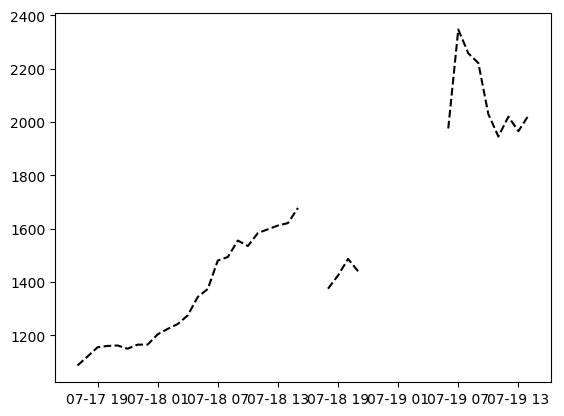

In [15]:
x = combined_cases[6].TLC.get_goes_data('2.3')
traj_data=x
hicf = traj_data.warm_low_cloud_fraction>0.5
cth = np.ma.masked_array(traj_data.cloud_top_height_75th_percentile*1000, mask=~hicf.values)
plt.plot(traj_data.time, cth, c='k', ls='--')
cth.data

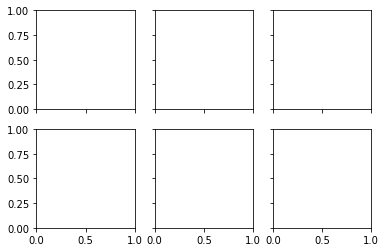

In [8]:
# for case_k, case in combined_cases.items():
# #     if case_k not in [6]:
# #         continue
#     out_ALC_profiles = {}
#     for out_seq in case.ALC.outbound_sequences:
#         profile_times = utils.get_leg_times_by_sequence(flightnum=int(case.ALC.outbound_flight[2:]), sequence=out_seq, leg='d')
#         fp = CSET_Flight_Piece(case.ALC.outbound_flight, *profile_times)
#         fp.add_ERA_data()
#         best_i = np.argmin(np.abs(fp.ERA_data.time.values - fp.flight_data.time.values[int(len(fp.flight_data.time.values)/2)]))
#         fp.ERA_data = fp.ERA_data.isel(time=best_i)
#         out_ALC_profiles[out_seq] = fp

#     ret_ALC_profiles = {}
#     for ret_seq in case.ALC.return_sequences:
#         profile_times = utils.get_leg_times_by_sequence(flightnum=int(case.ALC.return_flight[2:]), sequence=ret_seq, leg='d')
#         fp = CSET_Flight_Piece(case.ALC.return_flight, *profile_times)
#         fp.add_ERA_data()
#         best_i = np.argmin(np.abs(fp.ERA_data.time.values - fp.flight_data.time.values[int(len(fp.flight_data.time.values)/2)]))
#         fp.ERA_data = fp.ERA_data.isel(time=best_i)
#         ret_ALC_profiles[ret_seq] = fp

#     out_time = case.ALC.outbound_flight_data.time.values[int(len(case.ALC.outbound_flight_data.time.values)/2)]
#     ret_time = case.ALC.return_flight_data.time.values[int(len(case.ALC.return_flight_data.time.values)/2)]

#     out_TLC_profiles = {}
#     ret_TLC_profiles = {}
#     for k,v in case.TLC.traj_data.items():
#         out_TLC_profiles[k] = v.sel(time=out_time, method='nearest')
#         ret_TLC_profiles[k] = v.sel(time=ret_time, method='nearest')    

#     def plot_profiles(ALC_profiles, TLC_profiles, title):

#         def plot_with_zi(ax, x, z, theta, **kwargs):
#             x = ax.plot(x, z, **kwargs)
#             inv = mu.heffter_pblht_1D(z, theta)
#             ax.axhline(inv['z_bot'], c=x[0].get_color(), ls=x[0].get_linestyle(), lw=x[0].get_linewidth())
#             return x

#         fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(10,8), sharey=True)
#         for k, ALC_prof in ALC_profiles.items():
#             theta = mu.theta_from_p_T(p=ALC_prof.ERA_data.level.values, T=ALC_prof.ERA_data.ERA_t.values)
#             ac = plot_with_zi(ax, ALC_prof.flight_data.RHUM, ALC_prof.flight_data.GGALT, ALC_prof.flight_data.THETA, label='GV (seq {})'.format(k), lw=3)
#             er = plot_with_zi(ax, ALC_prof.ERA_data.ERA_r, ALC_prof.ERA_data.ERA_z/9.81, theta, ls='--', label='ERA (seq {})'.format(k), c=ac[0].get_color(), lw=3)

#             ac = plot_with_zi(ax2, ALC_prof.flight_data.THETA, ALC_prof.flight_data.GGALT, ALC_prof.flight_data.THETA, label='GV (seq {})'.format(k), lw=3)
#             er = plot_with_zi(ax2, theta, ALC_prof.ERA_data.ERA_z/9.81, theta, ls='--', label='ERA (seq {})'.format(k), c=ac[0].get_color(), lw=3)


#         for k, TLC_prof in TLC_profiles.items():
#             theta = mu.theta_from_p_T(p=TLC_prof.level.values, T=TLC_prof.ERA_t.values)
#             er_t = plot_with_zi(ax, TLC_prof.ERA_r, TLC_prof.ERA_z/9.81, theta, ls=':', label='ERA (traj {})'.format(k))

#             er_t = plot_with_zi(ax2, theta, TLC_prof.ERA_z/9.81, theta, ls=':', label='ERA (traj {})'.format(k))

#         ax.set_xlabel('Rel Hum (%)')
#         ax2.set_xlabel('Pot Temp (K)')
#         ax.set_ylabel("alt (m)")
#         ax.legend()
#         ax.set_ylim(0,2800)
#         ax2.set_xlim(280, 310)
#         ax.grid(True)
#         ax2.grid(True)

#         endstr = " (horizontal lines mark inversion base)"
#         fig.suptitle(title + endstr, y=1.02)
#         plt.tight_layout()
# #         fig.savefig(os.path.join(utils.plot_dir, '_'.join(title.split(' '))+'.png'), dpi=300)



#     plot_profiles(out_ALC_profiles, out_TLC_profiles, title="case {:02d} aircraft vs ERA soundings, outbound".format(case_k))
#     plot_profiles(ret_ALC_profiles, ret_TLC_profiles, title="case {:02d} aircraft vs ERA soundings, return".format(case_k))

        

In [16]:
table_data = utils.read_CSET_Lookup_Table(rf_num='all', sequences=None, legs='d', variables=['Lat_S', 'Lon_S', 'Lat_E', 'Lon_E', 'Date', 'ST', 'ET'])
start_times = utils.as_datetime([utils.CSET_date_from_table(d, t) for d, t in
               zip(table_data['Date']['values'], table_data['ST']['values'])])
end_times = utils.as_datetime([utils.CSET_date_from_table(d, t) for d, t in
             zip(table_data['Date']['values'], table_data['ET']['values'])])
profile_horiz_dist = np.sqrt((table_data['Lon_S']['values']-table_data['Lon_E']['values'])**2+(table_data['Lat_S']['values']-table_data['Lat_E']['values'])**2)
good_i = profile_horiz_dist<2
lats = (table_data['Lat_S']['values']+table_data['Lat_E']['values'])/2
lons = (table_data['Lon_S']['values']+table_data['Lon_E']['values'])/2
sounding_times = list(zip(table_data['rf'][good_i], lats[good_i], lons[good_i], start_times[good_i], end_times[good_i]))

sonde_files = glob.glob(r'/home/disk/eos4/jkcm/Data/CSET/AVAPS/NETCDF/*.nc')
dropsondes = []
for f in sonde_files:
    snd = utils.get_data_from_dropsonde(f)
    dropsondes.append(snd)
print("done ({:%H:%M})".format(dt.datetime.now()))

done (21:53)


In [63]:
ac_profiles = []
for s in sounding_times:
    fp = CSET_Flight_Piece('RF{:02}'.format(s[0]), s[3], s[4])
    prof = mu.calc_decoupling_and_zi_from_flight_data(fp.flight_data)
    p=fp.flight_data.PSX.values
    t=fp.flight_data.ATX.values+273.15
    theta = mu.theta_from_p_T(p=p, T=t)
    z=fp.flight_data.GGALT.values
    inv = mu.DEC_heffter_pblht_1D(z, theta)
    prof['Heff']=inv
    ac_profiles.append(prof)
ac_ERA_profiles = []
with xr.open_mfdataset(sorted(glob.glob(r'/home/disk/eos4/jkcm/Data/CSET/ERA5/ERA5.pres.NEP.*.nc'))) as data:                   
    for s in sounding_times:
        col = data.sel(latitude=s[1], longitude=s[2]%360, time=s[3].replace(tzinfo=None), method='nearest')
        ac_ERA_profiles.append(col)
print("done ({:%H:%M})".format(dt.datetime.now()))

done (18:56)


In [67]:
snd_profiles = []
snd_ERA_profiles = []
with xr.open_mfdataset(sorted(glob.glob(r'/home/disk/eos4/jkcm/Data/CSET/ERA5/ERA5.pres.NEP.*.nc'))) as data:                   
    for snd in dropsondes:
        decoupling_dict = mu.calc_decoupling_and_inversion_from_sounding(snd, usetheta=False, smooth_t=False)
        p=snd['PSX']
        t=snd['ATX']
        z=snd['GGALT']
        theta = mu.theta_from_p_T(p=p, T=t)
        inv = mu.DEC_heffter_pblht_1D(z, theta)
        decoupling_dict['Heff'] = inv
#         zi_dict = mu.calc_zi_from_sounding(snd)
        snd_profiles.append({**decoupling_dict})
        col = data.sel(latitude=np.nanmean(snd['GGLAT']), longitude=np.nanmean(snd['GGLON'])%360, time=snd['TIME'][0].replace(tzinfo=None), method='nearest')
        snd_ERA_profiles.append(col)
print("done ({:%H:%M})".format(dt.datetime.now()))

done (18:58)


In [68]:
profiles = ac_profiles + snd_profiles
ERA_profiles = ac_ERA_profiles + snd_ERA_profiles
ac_i = np.arange(len(ERA_profiles))<len(ac_profiles)

In [69]:
ERA_invs = []
for prof in ERA_profiles:
    p = prof.level.values
    t = prof.t.values
    r = prof.r.values
    z = prof.z.values/9.81

    theta = mu.theta_from_p_T(p=p, T=t)
    inv = mu.DEC_heffter_pblht_1D(z, theta)
    
    sounding_dict = {}
    sounding_dict['GGALT'] = z
    sounding_dict['GGLAT'] = [prof.latitude]
    sounding_dict['GGLON'] = [prof.longitude]
    sounding_dict['TIME'] = [prof.time]

    sounding_dict['THETA'] = theta
    sounding_dict['THETAE'] = theta ## DO NOT USE THETAE FROM THIS, just a filler
    sounding_dict['QV'] = mu.qv_from_p_T_RH(p*100, t, r)
    sounding_dict['ATX'] = t
    sounding_dict['PSXC'] = p
    sounding_dict['RHUM'] = r
    
    try:
        i_min = np.where(z == z[r < 50].min())[0][0]
        z_i = z[i_min]
        rh_50_inv = True
        if z_i>3000:
            i_min = float('nan')
            z_i = float('nan')
            rh_50_inv = False
    except ValueError as v:
        raise v
    RH_50 = {'i': i_min, 'inversion': rh_50_inv, 'z': z_i}
    
    decoupling_dict = mu.calc_decoupling_and_inversion_from_sounding(sounding_dict, usetheta=True, smooth_t=False)
#     zi_dict = mu.calc_zi_from_sounding(sounding_dict)

    lat = prof.latitude.values.item()
    lon = prof.longitude.values.item()-360
    lon_p = utils.get_lon_prime(lat, lon)
    time = prof.time.values
    ERA_invs.append({**decoupling_dict, "Heff": inv, "RH_50": RH_50, "lat": lat, "lon": lon, "lon_p": lon_p, "time": time})
print("done ({:%H:%M})".format(dt.datetime.now()))

done (19:01)


In [70]:
era_lats = np.array([i['lat'] for i in ERA_invs])
era_lons = np.array([i['lon'] for i in ERA_invs])
era_lon_ps = np.array([i['lon_p'] for i in ERA_invs])
era_times = np.array([utils.as_datetime(i['time']) for i in ERA_invs])

gv_lats = np.array([i['lat'] for i in profiles])
gv_lons = np.array([i['lon'] for i in profiles])
gv_lon_ps = np.array([i['lon_p'] for i in profiles])

gv_times = utils.as_datetime(np.array([i['time'] for i in profiles]))

dist = np.sqrt((gv_lats-era_lats)**2 + (gv_lons-era_lons)**2)
time_dist =np.array([i.total_seconds() for i in (gv_times-era_times)])/3600
print("done ({:%H:%M})".format(dt.datetime.now()))

done (19:01)


done (19:02)


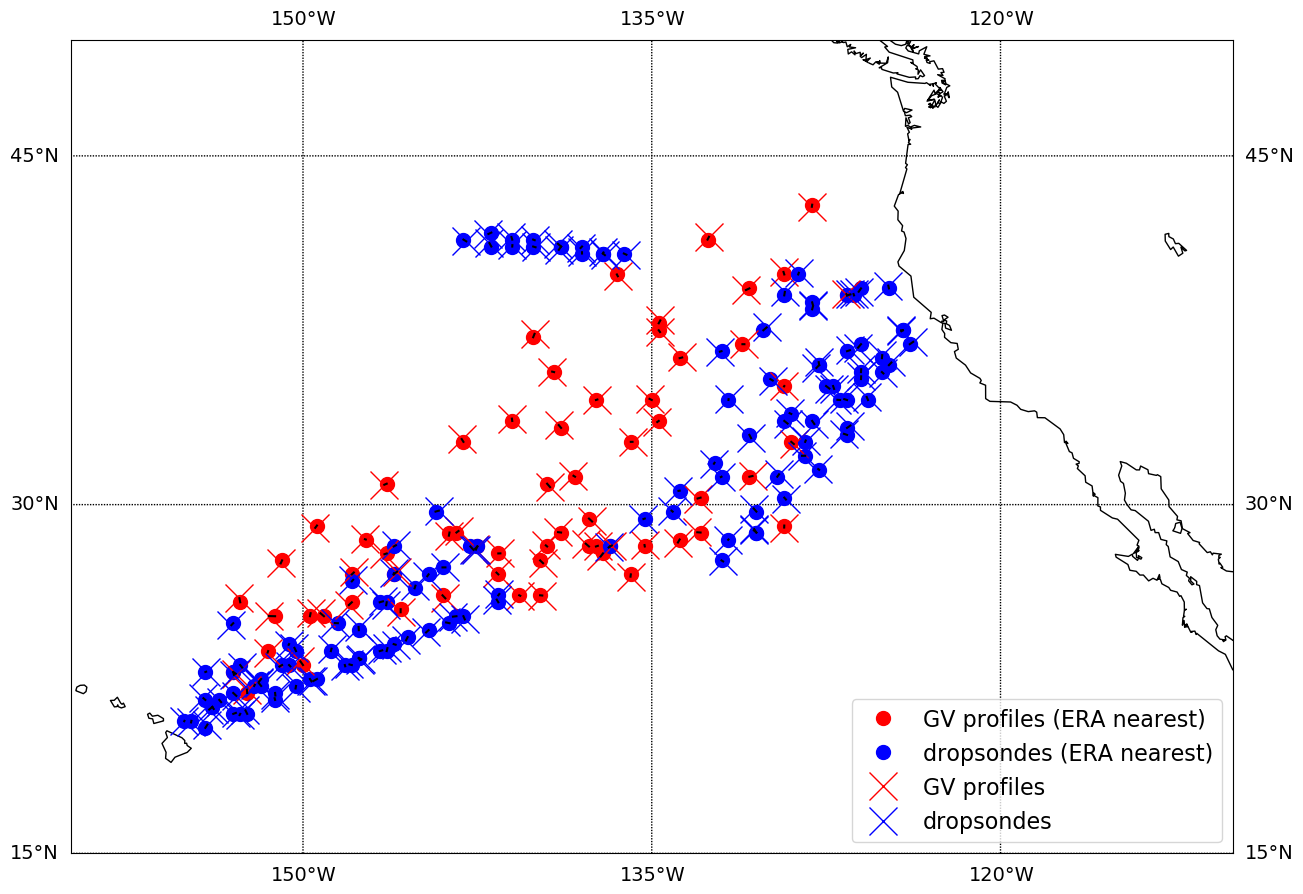

In [71]:
fig, ax = plt.subplots(figsize=(15,15,))
m = utils.bmap(ax=ax)
m.plot(era_lons[ac_i], era_lats[ac_i], '.r', latlon=True, label='GV profiles (ERA nearest)')
m.plot(era_lons[~ac_i], era_lats[~ac_i], '.b', latlon=True, label='dropsondes (ERA nearest)')
m.plot(gv_lons[ac_i], gv_lats[ac_i], 'xr', latlon=True, label='GV profiles')
m.plot(gv_lons[~ac_i], gv_lats[~ac_i], 'xb', latlon=True, label='dropsondes')
for gv_lon, gv_lat, era_lon, era_lat in zip(gv_lons, gv_lats, era_lons, era_lats):
    m.plot([gv_lon, era_lon], [gv_lat, era_lat], '-k', latlon=True)
plt.legend()
print("done ({:%H:%M})".format(dt.datetime.now()))

In [72]:
ERA_heff_zi = np.array([i['Heff']['z_bot'] for i in ERA_invs])
ac_heff_zi = np.array([i['Heff']['z_bot'] for i in profiles])

LinregressResult(slope=1.167338265720742, intercept=382.8557656062146, rvalue=0.7189932938453637, pvalue=2.064235523803187e-30, stderr=0.0838741299896438)
done (19:02)


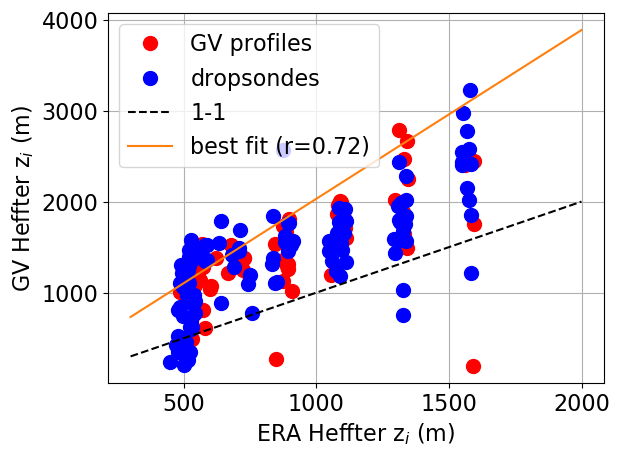

In [73]:
fig, ax = plt.subplots()
ax.plot(ERA_heff_zi[ac_i], ac_heff_zi[ac_i], '.r', label='GV profiles')
ax.plot(ERA_heff_zi[~ac_i], ac_heff_zi[~ac_i], '.b', label='dropsondes')

ax.plot([300, 2000], [300, 2000], '--k', label='1-1')
# ax.set_xlim([300, 3000])
ax.set_xlabel("ERA Heffter z$_i$ (m)")
ax.set_ylabel("GV Heffter z$_i$ (m)");
ax.grid(True)
mask = ~np.isnan(ERA_heff_zi) & ~np.isnan(ac_heff_zi)
lr = stats.linregress(ERA_heff_zi[mask], ac_heff_zi[mask])
print(lr)
plt.plot([300, 2000], [300*lr.slope+lr.intercept, 3000*lr.slope+lr.intercept], label='best fit (r={:0.2f})'.format(lr.rvalue))
plt.legend()
print("done ({:%H:%M})".format(dt.datetime.now()))

LinregressResult(slope=0.7367041684299909, intercept=393.3803205911322, rvalue=0.7358804020607838, pvalue=1.7914535248309268e-32, stderr=0.05038564431597362)
done (19:15)


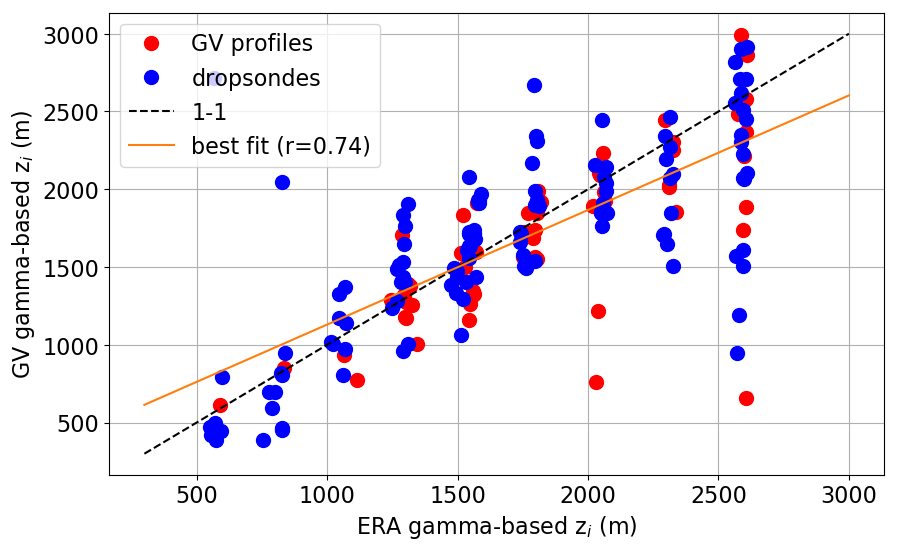

In [81]:
ERA_gamma_zi = np.array([i['z_mid'] for i in ERA_invs])
ac_gamma_zi = np.array([i['z_mid'] for i in profiles])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(ERA_gamma_zi[ac_i], ac_gamma_zi[ac_i], '.r', label='GV profiles')
ax.plot(ERA_gamma_zi[~ac_i], ac_gamma_zi[~ac_i], '.b', label='dropsondes')
ax.plot([300, 3000], [300, 3000], '--k', label='1-1')
# ax.set_xlim([300, 3000])
ax.set_xlabel("ERA gamma-based z$_i$ (m)")
ax.set_ylabel("GV gamma-based z$_i$ (m)");
ax.grid(True)
mask = ~np.isnan(ERA_gamma_zi) & ~np.isnan(ac_gamma_zi)
lr = stats.linregress(ERA_gamma_zi[mask], ac_gamma_zi[mask])
print(lr)
plt.plot([300, 3000], [300*lr.slope+lr.intercept, 3000*lr.slope+lr.intercept], label='best fit (r={:0.2f})'.format(lr.rvalue))
plt.legend()
print("done ({:%H:%M})".format(dt.datetime.now()))

In [75]:
ERA_RH50_zi = np.array([i['RH_50']['z'] for i in ERA_invs])
ac_RH50_zi = np.array([i['RH50']['z'] for i in profiles])

fig, ax = plt.subplots()
ax.plot(ERA_RH50_zi[ac_i], ac_RH50_zi[ac_i], '.r', label='GV profiles')
ax.plot(ERA_RH50_zi[~ac_i], ac_RH50_zi[~ac_i], '.b', label='dropsondes')
ax.plot([300, 3000], [300, 3000], '--k', label='1-1')
ax.set_xlim([300, 3000])
ax.set_xlabel("ERA RH$_{50}$ z$_i$ (m)")
ax.set_ylabel("GV  RH$_{50}$ z$_i$ (m)");
ax.grid(True)
mask = ~np.isnan(ERA_RH50_zi) & ~np.isnan(ac_RH50_zi) 
# mask = np.logical_and(mask, ERA_RH50_zi<3000)
lr = stats.linregress(ERA_RH50_zi[mask], ac_RH50_zi[mask])
print(lr)
plt.plot([300, 3000], [300*lr.slope+lr.intercept, 3000*lr.slope+lr.intercept], label='best fit (r={:0.2f})'.format(lr.rvalue))
plt.legend()
print("done ({:%H:%M})".format(dt.datetime.now()))

KeyError: 'RH50'

LinregressResult(slope=0.7342214856699967, intercept=643.6922430496767, rvalue=0.739911692481273, pvalue=5.464217437517927e-33, stderr=0.04961716304590528)
done (19:02)


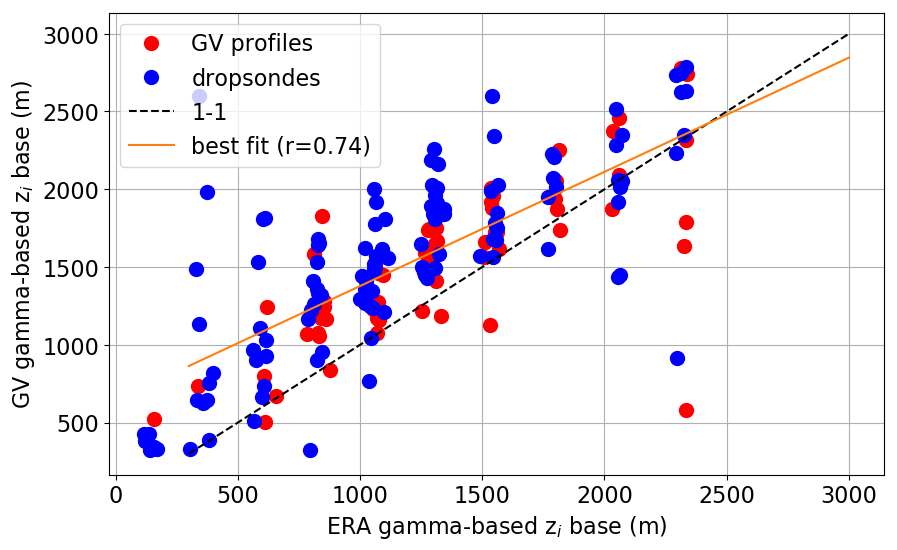

In [76]:
ERA_gamma_bot_zi = np.array([i['z_bot'] for i in ERA_invs])
ac_gamma_bot_zi = np.array([i['z_bot'] for i in profiles])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(ERA_gamma_bot_zi[ac_i], ac_gamma_bot_zi[ac_i], '.r', label='GV profiles')
ax.plot(ERA_gamma_bot_zi[~ac_i], ac_gamma_bot_zi[~ac_i], '.b', label='dropsondes')
ax.plot([300, 3000], [300, 3000], '--k', label='1-1')
# ax.set_xlim([300, 3000])
ax.set_xlabel("ERA gamma-based z$_i$ base (m)")
ax.set_ylabel("GV gamma-based z$_i$ base (m)");
ax.grid(True)
mask = ~np.isnan(ERA_gamma_bot_zi) & ~np.isnan(ac_gamma_bot_zi)
lr = stats.linregress(ERA_gamma_bot_zi[mask], ac_gamma_bot_zi[mask])
print(lr)
plt.plot([300, 3000], [300*lr.slope+lr.intercept, 3000*lr.slope+lr.intercept], label='best fit (r={:0.2f})'.format(lr.rvalue))
plt.legend()
print("done ({:%H:%M})".format(dt.datetime.now()))

LinregressResult(slope=0.7323516403733605, intercept=134.92894406929213, rvalue=0.592761193432933, pvalue=1.3560696137364231e-13, stderr=0.08829537296574932)
done (19:06)


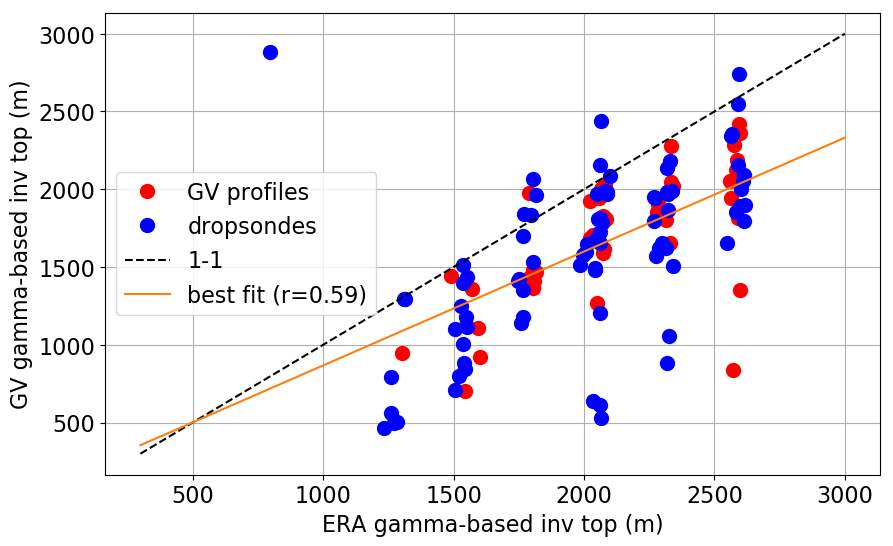

In [78]:
ERA_gamma_top_zi = np.array([i['z_top'] for i in ERA_invs])
ERA_gamma_top_zi[ERA_gamma_top_zi>3000] = np.nan
ac_gamma_top_zi = np.array([i['z_top'] for i in profiles])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(ERA_gamma_top_zi[ac_i], ac_gamma_top_zi[ac_i], '.r', label='GV profiles')
ax.plot(ERA_gamma_top_zi[~ac_i], ac_gamma_top_zi[~ac_i], '.b', label='dropsondes')
ax.plot([300, 3000], [300, 3000], '--k', label='1-1')
# ax.set_xlim([300, 3000])
ax.set_xlabel("ERA gamma-based inv top (m)")
ax.set_ylabel("GV gamma-based inv top (m)");
ax.grid(True)
mask = ~np.isnan(ERA_gamma_top_zi) & ~np.isnan(ac_gamma_top_zi)
lr = stats.linregress(ERA_gamma_top_zi[mask], ac_gamma_top_zi[mask])
print(lr)
plt.plot([300, 3000], [300*lr.slope+lr.intercept, 3000*lr.slope+lr.intercept], label='best fit (r={:0.2f})'.format(lr.rvalue))
plt.legend()
print("done ({:%H:%M})".format(dt.datetime.now()))

LinregressResult(slope=0.8336264372880641, intercept=356.6348338444393, rvalue=0.8507498084372035, pvalue=1.8882704445393717e-52, stderr=0.038279092830641244)
done (19:08)


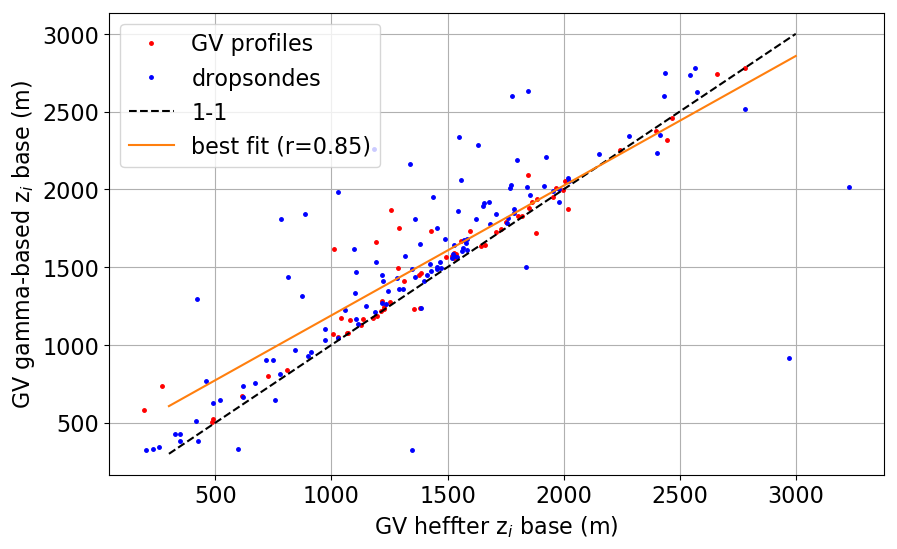

In [80]:
ac_heff_zi = np.array([i['Heff']['z_bot'] for i in profiles])
ac_gamma_bot_zi = np.array([i['z_bot'] for i in profiles])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(ac_heff_zi[ac_i], ac_gamma_bot_zi[ac_i], '.r', ms=5, label='GV profiles')
ax.plot(ac_heff_zi[~ac_i], ac_gamma_bot_zi[~ac_i], '.b', ms=5, label='dropsondes')
ax.plot([300, 3000], [300, 3000], '--k', label='1-1')
# ax.set_xlim([300, 3000])
ax.set_xlabel("GV heffter z$_i$ base (m)")
ax.set_ylabel("GV gamma-based z$_i$ base (m)");
ax.grid(True)
mask = ~np.isnan(ac_heff_zi) & ~np.isnan(ac_gamma_bot_zi)
lr = stats.linregress(ac_heff_zi[mask], ac_gamma_bot_zi[mask])
print(lr)
plt.plot([300, 3000], [300*lr.slope+lr.intercept, 3000*lr.slope+lr.intercept], label='best fit (r={:0.2f})'.format(lr.rvalue))
plt.legend()
print("done ({:%H:%M})".format(dt.datetime.now()))

done (13:07)


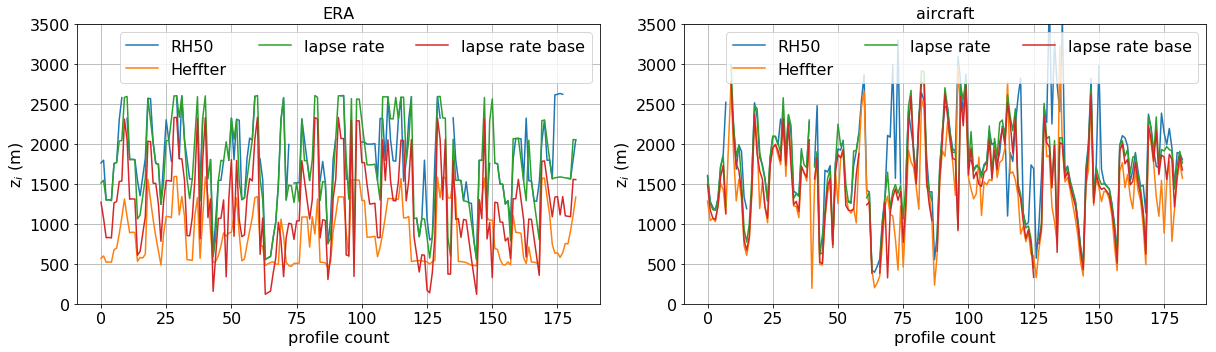

In [484]:
fig, [ax1, ax2] = plt.subplots(figsize=(17, 5), ncols=2)
ax1.plot(ERA_RH50_zi, label='RH50')
ax1.plot(ERA_heff_zi, label='Heffter')
ax1.plot(ERA_gamma_zi, label='lapse rate')
ax1.plot(ERA_gamma_bot_zi, label='lapse rate base')

ax1.legend(ncol=3)
ax1.set_title('ERA')


ax2.plot(ac_RH50_zi, label='RH50')
ax2.plot(ac_heff_zi, label='Heffter')
ax2.plot(ac_gamma_zi, label='lapse rate')
ax2.plot(ac_gamma_bot_zi, label='lapse rate base')


ax2.legend(ncol=3)
ax2.set_title('aircraft')

for ax in (ax1, ax2):
    ax.set_ylim([0, 3500])
    ax.set_ylabel('z$_i$ (m)')
    ax.grid(True)
    ax.set_xlabel("profile count")
plt.tight_layout()
print("done ({:%H:%M})".format(dt.datetime.now()))

In [485]:
df = pd.DataFrame.from_dict({"ac_RH50": ac_RH50_zi, "ac_heff": ac_heff_zi, "ac_gamm": ac_gamma_zi, "ac_gamm_base": ac_gamma_bot_zi,
                            "ERA_RH50": ERA_RH50_zi, "ERA_heff": ERA_heff_zi, "ERA_gamm": ERA_gamma_zi, "ERA_gamm_base": ERA_gamma_bot_zi,})
print("done ({:%H:%M})".format(dt.datetime.now()))
df.corr()

done (13:07)


,ERA_RH50,ERA_gamm,ERA_gamm_base,ERA_heff,ac_RH50,ac_gamm,ac_gamm_base,ac_heff
ERA_RH50,1.000000,0.823734,0.806331,0.657896,0.796407,0.771623,0.717587,0.748023
ERA_gamm,0.823734,1.000000,0.872535,0.736447,0.626498,0.729365,0.705269,0.739313
ERA_gamm_base,0.806331,0.872535,1.000000,0.716440,0.596005,0.756346,0.741516,0.741184
ERA_heff,0.657896,0.736447,0.716440,1.000000,0.645940,0.699069,0.686239,0.723315
ac_RH50,0.796407,0.626498,0.596005,0.645940,1.000000,0.660415,0.654981,0.665049
ac_gamm,0.771623,0.729365,0.756346,0.699069,0.660415,1.000000,0.969399,0.825719
ac_gamm_base,0.717587,0.705269,0.741516,0.686239,0.654981,0.969399,1.000000,0.823093
ac_heff,0.748023,0.739313,0.741184,0.723315,0.665049,0.825719,0.823093,1.000000


In [493]:
np.sqrt(np.nanmean((ac_gamma_zi-ERA_gamma_zi)**2))
np.sqrt(np.nanmean((ac_RH50_zi-ERA_RH50_zi)**2))

332.10303156948925

In [494]:
len(ac_RH50_zi)

183

In [83]:
#biases:
print("done ({:%H:%M})".format(dt.datetime.now()))
print("aircraft median biases:")
# print("rh50-heff: {:0.0f} m".format(np.nanmedian(ac_RH50_zi-ac_heff_zi)))
# print("rh50-gamma: {:0.0f} m".format(np.nanmedian(ac_RH50_zi-ac_gamma_zi)))
print("gamma-heff: {:0.0f} m".format(np.nanmedian(ac_gamma_zi-ac_heff_zi)))
print("gamma_base-heff: {:0.0f} m".format(np.nanmedian(ac_gamma_bot_zi-ac_heff_zi)))


print("\nERA median biases:")
# print("rh50-heff: {:0.0f} m".format(np.nanmedian(ERA_RH50_zi-ERA_heff_zi)))
# print("rh50-gamma: {:0.0f} m".format(np.nanmedian(ERA_RH50_zi-ERA_gamma_zi)))
print("gamma-heff: {:0.0f} m".format(np.nanmedian(ERA_gamma_zi-ERA_heff_zi)))
print("gamma_base-heff: {:0.0f} m".format(np.nanmedian(ERA_gamma_bot_zi-ERA_heff_zi)))


print('\nx-source biases:')
# print("rh50 ac-ERA: {:0.0f} m".format(np.nanmedian(ac_RH50_zi-ERA_RH50_zi)))
print("gamma ac-ERA: {:0.0f} m".format(np.nanmedian(ac_gamma_zi-ERA_gamma_zi)))
# print("gamma ac-ERA RMSE: {:0.0f} m".format(np.sqrt((ac_gamma_zi-ERA_gamma_zi)**2)))
print("heff ac-ERA: {:0.0f} m".format(np.nanmedian(ac_heff_zi-ERA_heff_zi)))
print("gamma_base ac-ERA: {:0.0f} m".format(np.nanmedian(ac_gamma_bot_zi-ERA_gamma_bot_zi)))
print("heff ac - gamma ERA: {:0.0f} m".format(np.nanmedian(ac_heff_zi-ERA_gamma_zi)))


done (19:16)
aircraft median biases:
gamma-heff: 189 m
gamma_base-heff: 68 m

ERA median biases:
gamma-heff: 915 m
gamma_base-heff: 415 m

x-source biases:
gamma ac-ERA: -29 m
heff ac-ERA: 574 m
gamma_base ac-ERA: 328 m
heff ac - gamma ERA: -250 m


## SUMMARY:
(note: all averages below are medians of differences over all profiles)

For ERA5, the Heffter method is not appropriate for determining the inversion height; the smoothed nature of the profiles (due to low vertical resolution) results in a significant low bias in the diagnosed heights relative to aircraft data. Using the height where RH<50% and using the peak lapse rate (or more specifically peak lapse rate deviation from moist adiabatic) give similar results, with two important points: 1) the RH<50% method is on average 115 m above the lapse rate method, and 2) the RH<50% method can fail spectalularly and requires some filtering for abnormally deep boundary layers. Based on this latter point we find that the lapse rate method is most appropriate for ERA5 inversion height estimation. 

For aircraft data, all three methods correlate well. On average the Heffter method inversion is 200 m below the RH<50% method and ~170 m below the lapse rate method, while the lapse rate method and RH<50% have no significant relative bias. 

Comparing between aircraft and ERA5, the correlation coefficients for RH<50%, lapse rate, and heffter are 0.86, 0.71, and 0.60 respectively. Median bias for these (aircraft-ERA) are -56 m, -23 m, and 650 m respectively (i.e. ERA is slightly above aircraft for inversion heights, except for Heffter inversions)

In [487]:
for case_k, case in combined_cases.items():
#     if case_k not in [6, 10]:
#         continue
    #chop out every aircraft profile, also get colocated ERA
    out_ALC_profiles = {}
    for out_seq in case.ALC.outbound_sequences:
        profile_times = utils.get_leg_times_by_sequence(flightnum=int(case.ALC.outbound_flight[2:]), sequence=out_seq, leg='d')
        fp = CSET_Flight_Piece(case.ALC.outbound_flight, *profile_times)
        fp.add_ERA_data()
        best_i = np.argmin(np.abs(fp.ERA_data.time.values - fp.flight_data.time.values[int(len(fp.flight_data.time.values)/2)]))
        fp.ERA_data = fp.ERA_data.isel(time=best_i)
        out_ALC_profiles[out_seq] = fp

    ret_ALC_profiles = {}
    for ret_seq in case.ALC.return_sequences:
        profile_times = utils.get_leg_times_by_sequence(flightnum=int(case.ALC.return_flight[2:]), sequence=ret_seq, leg='d')
        fp = CSET_Flight_Piece(case.ALC.return_flight, *profile_times)
        fp.add_ERA_data()
        best_i = np.argmin(np.abs(fp.ERA_data.time.values - fp.flight_data.time.values[int(len(fp.flight_data.time.values)/2)]))
        fp.ERA_data = fp.ERA_data.isel(time=best_i)
        ret_ALC_profiles[ret_seq] = fp

    #rough estimate of when the outbound and return samplings were
    out_time = case.ALC.outbound_flight_data.time.values[int(len(case.ALC.outbound_flight_data.time.values)/2)]
    ret_time = case.ALC.return_flight_data.time.values[int(len(case.ALC.return_flight_data.time.values)/2)]

    # chop out ERA profiles from trajectory start/resampling points
    out_TLC_profiles = {}
    ret_TLC_profiles = {}
    for k,v in case.TLC.traj_data.items():
        out_TLC_profiles[k] = v.sel(time=out_time, method='nearest')
        ret_TLC_profiles[k] = v.sel(time=ret_time, method='nearest')    

    def plot_profiles(ALC_profiles, TLC_profiles, title):

        def plot_with_zi(axi, x, z, theta, rh=None, method='Peter2', **kwargs):
            if method=='heffter':
                inv = mu.heffter_pblht_1D(z, theta)
            elif method=='Peter2':
                inv = {}
                inv['z_bot'] = mu.Peter2_inv(z, rh, theta)
#             elif method=='Peter1':
#                 inv = {}
#                 inv['z_bot'] = mu.Peter2_inv(z, theta, rh)
            
            lab = 'inv={:0.0f} m'.format(inv['z_bot'])
            x = axi.plot(x, z, **kwargs)
            axi.axhline(inv['z_bot'], c=x[0].get_color(), ls=x[0].get_linestyle(), lw=x[0].get_linewidth(), label=lab)
            return x

        fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(10,8), sharey=True)
        for k, ALC_prof in ALC_profiles.items():
            theta = mu.theta_from_p_T(p=ALC_prof.ERA_data.level.values, T=ALC_prof.ERA_data.ERA_t.values)
            ac = plot_with_zi(ax, x=ALC_prof.flight_data.RHUM.values, z=ALC_prof.flight_data.GGALT.values, theta=ALC_prof.flight_data.THETA.values, rh=ALC_prof.flight_data.RHUM.values, method='heffter',
                              label='GV (seq {})'.format(k), lw=3)
            er = plot_with_zi(ax, x=ALC_prof.ERA_data.ERA_r.values, z=ALC_prof.ERA_data.ERA_z.values/9.81, theta=theta, rh=ALC_prof.ERA_data.ERA_r.values,
                              label='ERA (seq {})'.format(k), ls='--', c=ac[0].get_color(), lw=3)

            ac = plot_with_zi(ax2, x=ALC_prof.flight_data.THETA.values, z=ALC_prof.flight_data.GGALT.values, theta=ALC_prof.flight_data.THETA.values, rh=ALC_prof.flight_data.RHUM.values, method='heffter',
                              label='GV (seq {})'.format(k), lw=3)
            er = plot_with_zi(ax2, x=theta, z=ALC_prof.ERA_data.ERA_z.values/9.81, theta=theta, rh=ALC_prof.ERA_data.ERA_r.values,
                              label='ERA (seq {})'.format(k), ls='--', c=ac[0].get_color(), lw=3)


        for k, TLC_prof in TLC_profiles.items():
            theta = mu.theta_from_p_T(p=TLC_prof.level.values, T=TLC_prof.ERA_t.values)
            er_t = plot_with_zi(ax, x=TLC_prof.ERA_r.values, z=TLC_prof.ERA_z.values/9.81, theta=theta, rh=TLC_prof.ERA_r.values,
                                label='ERA (traj {})'.format(k), ls=':')
            er_t = plot_with_zi(ax2, x=theta, z=TLC_prof.ERA_z.values/9.81, theta=theta, rh=TLC_prof.ERA_r.values,
                                label='ERA (traj {})'.format(k), ls=':')

        ax.set_xlabel('Rel Hum (%)')
        ax2.set_xlabel('Pot Temp (K)')
        ax.set_ylabel("alt (m)")
        ax.legend()
        ax.set_ylim(0,3000)
        ax2.set_xlim(280, 310)
        ax.grid(True)
        ax2.grid(True)

        endstr = " (horizontal lines mark inversion base)"
        fig.suptitle(title + endstr, y=1.02)
        plt.tight_layout()
#         fig.savefig(os.path.join(utils.plot_dir, '_'.join(title.split(' '))+'.png'), dpi=300)



    plot_profiles(out_ALC_profiles, out_TLC_profiles, title="case {:02d} outbound soundings".format(case_k))
    plot_profiles(ret_ALC_profiles, ret_TLC_profiles, title="case {:02d} return soundings".format(case_k))

NameError: name 'combined_cases' is not defined

In [36]:
prof = out_TLC_profiles['2.0']
z = prof.ERA_z.values/9.81
t = prof.ERA_t.values
p = prof.level.values
rh = prof.ERA_r.values
theta = mu.theta_from_p_T(p=p, T=t)
inv = mu.Peter2_inv(z, theta, rh)

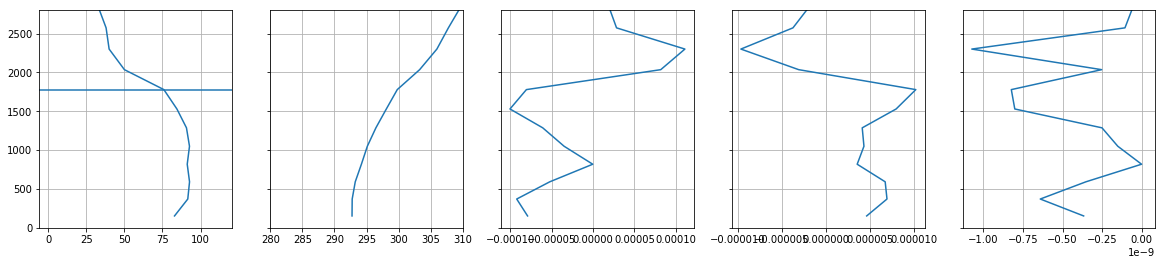

In [37]:
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(ncols=5,sharey=True, figsize=(20,4))
ax1.plot(rh, z)
# ax1.axhline(inv['z_bot'])
# ax1.axhline(inv['z_top'])
ax1.set_ylim(0, 2800)


ax2.plot(theta,z)
ax2.set_xlim(280, 310)

grad2_rh = np.gradient(np.gradient(rh, z), z)
grad2_theta = np.gradient(np.gradient(theta, z), z)
ax3.plot(grad2_rh, z)
ax4.plot(grad2_theta, z)

grad2_prod = grad2_rh*grad2_theta
ax5.plot(grad2_prod, z)

[ax.grid(True) for ax in [ax1, ax2, ax3, ax4, ax5]]

ax1.axhline(mu.Peter2_inv(z, rh, theta))